In [20]:
import sys
import time

import spotipy
import yaml
import spotipy.util as util
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.graph_objects as go
# from yellowbrick.cluster import KElbowVisualizer
# from kneed import KneeLocator
from plotly.subplots import make_subplots
# import networkx as nx
# import mpld3
from requests.exceptions import HTTPError
mpld3.enable_notebook()

sns.set()

## Spotipy Credentials and API Calls

In [5]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [28]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["track_name", "artist", "track_URI"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset]
        df.loc[len(df.index)] = row
    return df



In [23]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# 设置你的客户端 ID 和客户端密钥
CLIENT_ID = '5ccd70c6cd434f7fa1d9987fb9ad5e92'
CLIENT_SECRET = '974676f604b147fa9ef23261eb6b90a6'
REDIRECT_URI = 'https://spotify.apkflames.com/playlist-generator'

# 设置范围，允许读取用户的私人歌单和合作歌单
SCOPE = 'playlist-read-private playlist-read-collaborative'

def get_token(scope):
    sp_oauth = SpotifyOAuth(client_id=CLIENT_ID,
                            client_secret=CLIENT_SECRET,
                            redirect_uri=REDIRECT_URI,
                            scope=scope)
    token_info = sp_oauth.get_access_token()
    return token_info['access_token']

# 获取访问令牌
token = get_token(SCOPE)

# 使用访问令牌创建Spotify对象
sp = spotipy.Spotify(auth=token)

# 指定你的歌单ID
playlist_id = '1mwIluT6YC7UOrVfMNoowr'

# 获取歌单的详细信息
playlist = sp.playlist(playlist_id)

# 打印歌单的详细信息
print(f"Playlist Name: {playlist['name']}")
print(f"Playlist Description: {playlist['description']}")
print(f"Total Tracks: {playlist['tracks']['total']}")

# 打印歌单中的前10首歌曲
for idx, item in enumerate(playlist['tracks']['items'][:10]):
    track = item['track']
    print(f"{idx + 1}: {track['name']} by {track['artists'][0]['name']}")


C:\Users\wuyuh\AppData\Local\Temp\ipykernel_21508\3070419387.py:17: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token_info = sp_oauth.get_access_token()


Playlist Name: All Taylor Swift Songs
Playlist Description: ALL TAYLOR SWIFT SONGS in order plus a few extras. All available taylors versions included. 🤍
Total Tracks: 262
1: Tim McGraw by Taylor Swift
2: Teardrops On My Guitar - Radio Single Remix by Taylor Swift
3: Picture To Burn by Taylor Swift
4: A Place in this World by Taylor Swift
5: Cold As You by Taylor Swift
6: The Outside by Taylor Swift
7: Tied Together with a Smile by Taylor Swift
8: Stay Beautiful by Taylor Swift
9: Should've Said No by Taylor Swift
10: Mary's Song (Oh My My My) by Taylor Swift


In [27]:



df = pd.DataFrame(columns=[
    'track_name', 'artist', 'track_URI', 'album_name', 'album_release_year', 
    'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 
    'liveness', 'mode', 'loudness', 'speechiness', 'tempo', 'valence'
])

# 初始化偏移量
offset = 0
limit = 1



# 获取歌单中的所有曲目，处理分页
while True:
    playlist_tracks = sp.playlist_tracks(playlist_id, offset=offset, limit=limit)
    items = playlist_tracks['items']
    
    if not items:
        break
    
    for item in items:
        track = item['track']
        track_name = track['name']
        artist = track['artists'][0]['name']
        track_URI = track['uri']
        
        print(track_URI)
        
        
        
        # 获取音频特征
        audio_features = sp.audio_features(track_URI)[0]
        
        # 获取专辑信息
        album_name = track['album']['name']
        album_release_year = track['album']['release_date'][:4]
        
        # 创建一个包含当前曲目信息的 DataFrame
        track_df = pd.DataFrame([{
            'track_name': track_name,
            'artist': artist,
            'track_URI': track_URI,
            'album_name': album_name,
            'album_release_year': album_release_year,
            'acousticness': audio_features['acousticness'],
            'danceability': audio_features['danceability'],
            'energy': audio_features['energy'],
            'instrumentalness': audio_features['instrumentalness'],
            'key': audio_features['key'],
            'liveness': audio_features['liveness'],
            'mode': audio_features['mode'],
            'loudness': audio_features['loudness'],
            'speechiness': audio_features['speechiness'],
            'tempo': audio_features['tempo'],
            'valence': audio_features['valence']
        }])
        
        # 使用 pd.concat 将 track_df 合并到 df 中
        df = pd.concat([df, track_df], ignore_index=True)
    
    # 更新偏移量
    offset += limit

# 将 DataFrame 导出为 JSON 文件
df.to_json('playlist_tracks.json', orient='records', lines=True)

print("Data successfully saved to playlist_tracks.json")

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/playlists/1mwIluT6YC7UOrVfMNoowr/tracks?limit=1&offset=0&additional_types=track:
 Max Retries, reason: too many 502 error responses

In [30]:
file_path = 'taylor_swift_spotify.csv'
df = pd.read_csv(file_path)
df

,Unnamed: 0,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,0,Fortnight (feat. Post Malone),THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,1,6dODwocEuGzHAavXqTbwHv,spotify:track:6dODwocEuGzHAavXqTbwHv,0.50200,0.504,0.386,0.000015,0.0961,-10.976,0.0308,192.004,0.281,89,228965
1,1,The Tortured Poets Department,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,2,4PdLaGZubp4lghChqp8erB,spotify:track:4PdLaGZubp4lghChqp8erB,0.04830,0.604,0.428,0.000000,0.1260,-8.441,0.0255,110.259,0.292,87,293048
2,2,My Boy Only Breaks His Favorite Toys,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,3,7uGYWMwRy24dm7RUDDhUlD,spotify:track:7uGYWMwRy24dm7RUDDhUlD,0.13700,0.596,0.563,0.000000,0.3020,-7.362,0.0269,97.073,0.481,88,203801
3,3,Down Bad,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,4,1kbEbBdEgQdQeLXCJh28pJ,spotify:track:1kbEbBdEgQdQeLXCJh28pJ,0.56000,0.541,0.366,0.000001,0.0946,-10.412,0.0748,159.707,0.168,89,261228
4,4,"So Long, London",THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,5,7wAkQFShJ27V8362MqevQr,spotify:track:7wAkQFShJ27V8362MqevQr,0.73000,0.423,0.533,0.002640,0.0816,-11.388,0.3220,160.218,0.248,88,262974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,561,Our Song,Taylor Swift,2006-10-24,11,1j6gmK6u4WNI33lMZ8dC1s,spotify:track:1j6gmK6u4WNI33lMZ8dC1s,0.11100,0.668,0.672,0.000000,0.3290,-4.931,0.0303,89.011,0.539,65,201106
562,562,I'm Only Me When I'm With You,Taylor Swift,2006-10-24,12,7CzxXgQXurKZCyHz9ufbo1,spotify:track:7CzxXgQXurKZCyHz9ufbo1,0.00452,0.563,0.934,0.000807,0.1030,-3.629,0.0646,143.964,0.518,55,213053
563,563,Invisible,Taylor Swift,2006-10-24,13,1k3PzDNjg38cWqOvL4M9vq,spotify:track:1k3PzDNjg38cWqOvL4M9vq,0.63700,0.612,0.394,0.000000,0.1470,-5.723,0.0243,96.001,0.233,53,203226
564,564,A Perfectly Good Heart,Taylor Swift,2006-10-24,14,0YgHuReCSPwTXYny7isLja,spotify:track:0YgHuReCSPwTXYny7isLja,0.00349,0.483,0.751,0.000000,0.1280,-5.726,0.0365,156.092,0.268,52,220146


In [118]:

# Standardize the feature columns before clustering
features = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 
               'liveness',  'loudness', 'speechiness', 
               'tempo', 'valence']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply k-means clustering
kmeans = KMeans(n_clusters=4, random_state=13)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Save the clustered DataFrame to a new JSON file
df.to_json('playlist_tracks_clustered.json', orient='records', lines=True)

print("Data successfully clustered and saved to playlist_tracks_clustered.json")

from sklearn.metrics import silhouette_score



Data successfully clustered and saved to playlist_tracks_clustered.json


#因为多次请求数据，api被spotify封禁，故使用kaggle上下载的spotify数据进行挖掘 ：https://www.kaggle.com/datasets/jarredpriester/taylor-swift-spotify-dataset?select=taylor_swift_spotify.csv

In [234]:
# 自定义K-means实现
def initialize_centroids(X, k):
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def compute_distances(X, centroids):
    distances = np.zeros((X.shape[0], centroids.shape[0]))
    for i in range(centroids.shape[0]):
        distances[:, i] = np.linalg.norm(X - centroids[i], axis=1)
    return distances

def assign_clusters(distances):
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        centroids[i] = X[labels == i].mean(axis=0)
    return centroids

def kmeans_mine(X, k, max_iters=10000, tol=1e-6):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        old_centroids = centroids
        distances = compute_distances(X, centroids)
        labels = assign_clusters(distances)
        centroids = update_centroids(X, labels, k)
        if np.linalg.norm(centroids - old_centroids) < tol:
            break
    return labels, centroids

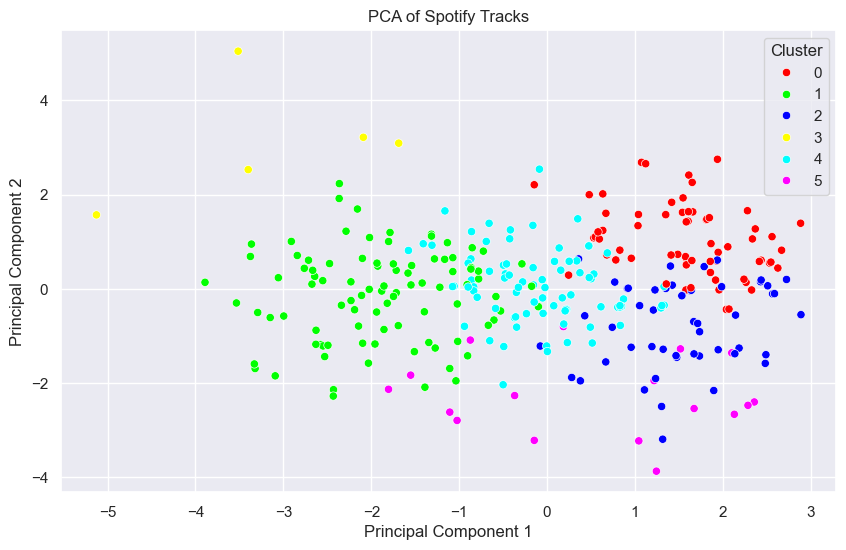

Data successfully clustered, PCA applied, and saved to playlist_tracks_clustered.csv


In [239]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件
file_path = 'taylor_swift_spotify.csv'
df = pd.read_csv(file_path)
df = df.dropna()

# 标准化特征数据
features = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 
               'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 进行PCA分析，将数据降维到2个主成分
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 将PCA结果添加到DataFrame中
df['pca_1'] = pca_features[:, 0]
df['pca_2'] = pca_features[:, 1]

k = 6
labels, centroids = kmeans_mine(scaled_features, k)
df['cluster'] = labels
custom_palette = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF']


# 可视化PCA结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', data=df, palette=custom_palette)
plt.title('PCA of Spotify Tracks')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# 保存聚类结果至CSV文件
output_file_path = 'playlist_tracks_clustered.csv'
df.to_csv(output_file_path, index=False)


print("Data successfully clustered, PCA applied, and saved to playlist_tracks_clustered.csv")


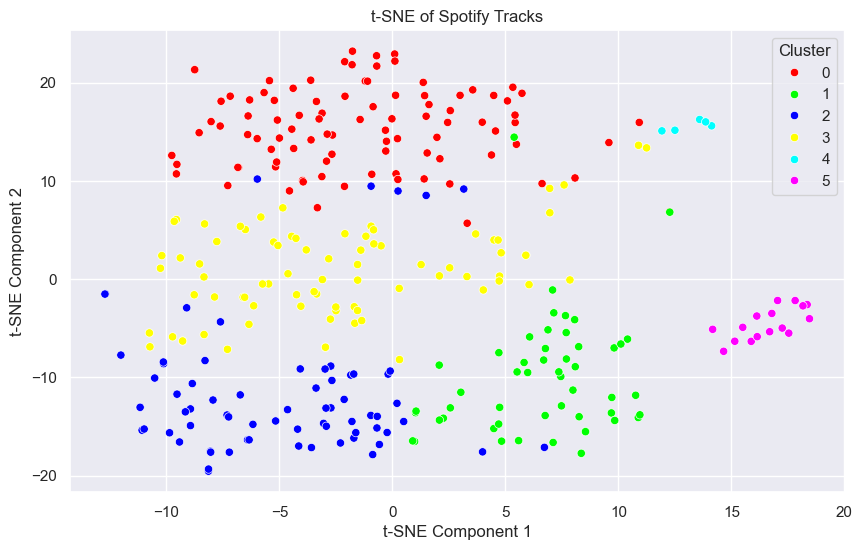

In [245]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 使用t-SNE将数据降维到2个主成分
tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(scaled_features)

# 将t-SNE结果添加到DataFrame中
df['tsne_1'] = tsne_features[:, 0]
df['tsne_2'] = tsne_features[:, 1]

# 假设你已经有了scaled_features，并且kmeans_mine函数已经定义
k = 6
labels, centroids = kmeans_mine(scaled_features, k)
df['cluster'] = labels
custom_palette = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF']

# 可视化t-SNE结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=df, palette=custom_palette)
plt.title('t-SNE of Spotify Tracks')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

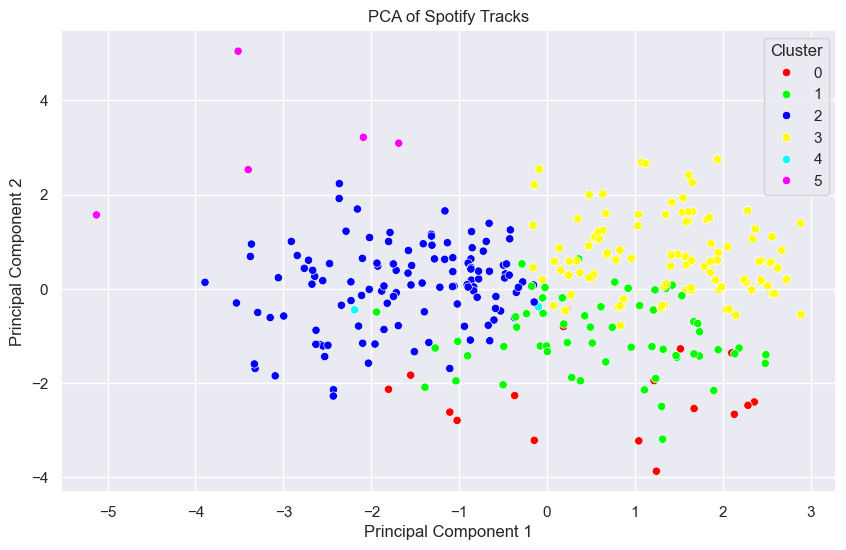

Data successfully clustered, PCA applied, and visualization with adjusted names generated.


In [244]:
from adjustText import adjust_text
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件
file_path = 'taylor_swift_spotify.csv'
df = pd.read_csv(file_path)
df = df.dropna()

# 标准化特征数据
features = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 
               'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 进行PCA分析，将数据降维到2个主成分
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 将PCA结果添加到DataFrame中
df['pca_1'] = pca_features[:, 0]
df['pca_2'] = pca_features[:, 1]

# 使用K-means进行聚类分析
kmeans = KMeans(n_clusters=6, random_state=13)
df['cluster'] = kmeans.fit_predict(scaled_features)
# 可视化PCA结果
plt.figure(figsize=(10 , 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', data=df, palette=custom_palette)




plt.title('PCA of Spotify Tracks')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

print("Data successfully clustered, PCA applied, and visualization with adjusted names generated.")


In [214]:
from sklearn.metrics import silhouette_score
def silhouette_score_manual(X, labels):
    n_samples = len(labels)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters == 1 or n_clusters == n_samples:
        return 0

    A = np.zeros(n_samples)
    B = np.zeros(n_samples)

    for i in range(n_samples):
        same_cluster = X[labels == labels[i]]
        other_clusters = X[labels != labels[i]]
        
        A[i] = np.mean(np.linalg.norm(same_cluster - X[i], axis=1))
        B[i] = np.min([np.mean(np.linalg.norm(other_clusters[labels[labels != labels[i]] == label] - X[i], axis=1)) 
                       for label in unique_labels if label != labels[i]])

    S = (B - A) / np.maximum(A, B)
    return np.mean(S)
# 计算轮廓系数
silhouette_avg_sk = silhouette_score(scaled_features, df['cluster'])
silhouette_avg_man = silhouette_score_manual(scaled_features, df['cluster'])
print(f"聚类的轮廓系数为：{silhouette_avg_sk}")
print(f"聚类的轮廓系数为：{silhouette_avg_man}")

聚类的轮廓系数为：0.23594718865489844
聚类的轮廓系数为：0.24805491995938878


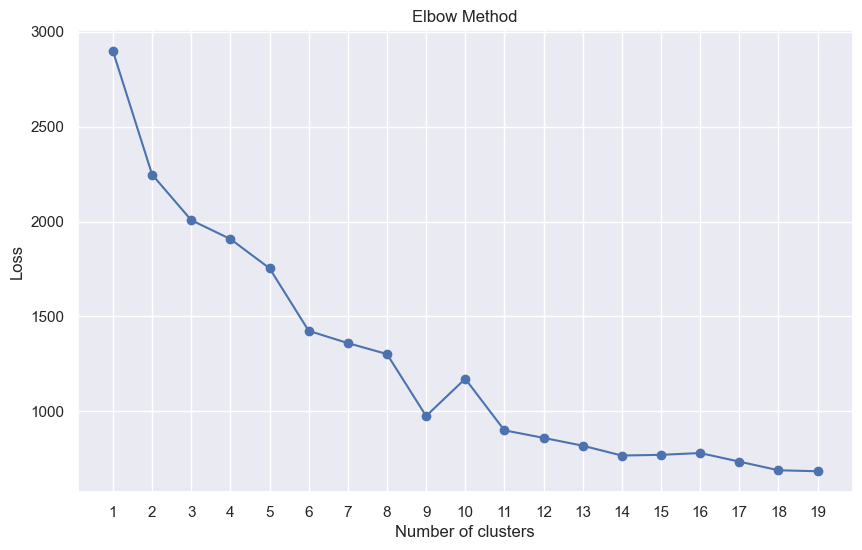

In [272]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# 读取CSV文件
file_path = 'taylor_swift_spotify.csv'
df = pd.read_csv(file_path)
df = df.dropna()

# 标准化特征数据
features = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 
               'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 存储不同聚类数量下的损失值
loss = []
from sklearn.metrics import pairwise_distances_argmin_min
# 尝试不同的聚类数量

for k in range(1, 20):
    labels, centroids = kmeans_mine(scaled_features, k)
    closest, distances = pairwise_distances_argmin_min(scaled_features, centroids)
    loss.append( np.sum(distances ** 2))



# 绘制肘部曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), loss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Loss')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()




In [255]:
from sklearn.metrics import silhouette_score

# 计算轮廓系数
silhouette_avg = silhouette_score(scaled_features, df['cluster'])
print(f"聚类的轮廓系数为：{silhouette_avg}")


KeyError: 'cluster'

In [222]:
# Group the DataFrame by the 'cluster' column
cluster_groups = df.groupby('cluster')

# Iterate over each cluster group and display the track names
for cluster, group in cluster_groups:
    print(f"Cluster {cluster}:")
    for track_name in group['name']:
        print(track_name)
    print("\n")



Cluster 0:
Karma
august - the long pond studio sessions
Sparks Fly - Live/2011
Mine - Live/2011
The Story Of Us - Live
Mean - Live/2011
Ours - Live/2011
Back To December/Apologize/You're Not Sorry - Live/2011/Medley
Better Than Revenge - Live/2011
Speak Now - Live/2011
Last Kiss - Live/2011
Drops Of Jupiter - Live/2011
Bette Davis Eyes - Live/2011
Dear John - Live/2011
Enchanted - Live/2011
Haunted - Live/2011
Long Live - Live/2011


Cluster 1:
Fortnight (feat. Post Malone)
So Long, London
Florida!!! (feat. Florence + The Machine)
The Albatross
So High School
The Prophecy
Peter
The Bolter
Bad Blood (feat. Kendrick Lamar) (Taylor's Version)
Electric Touch (feat. Fall Out Boy) (Taylor’s Version) (From The Vault)
Castles Crumbling (feat. Hayley Williams) (Taylor’s Version) (From The Vault)
Bejeweled
High Infidelity
Would've, Could've, Should've
I Bet You Think About Me (feat. Chris Stapleton) (Taylor’s Version) (From The Vault)
mad woman
Cruel Summer
The Archer
...Ready For It?
End Game
D

C:\Users\wuyuh\AppData\Local\Temp\ipykernel_21508\4075169360.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data.dropna(inplace=True)


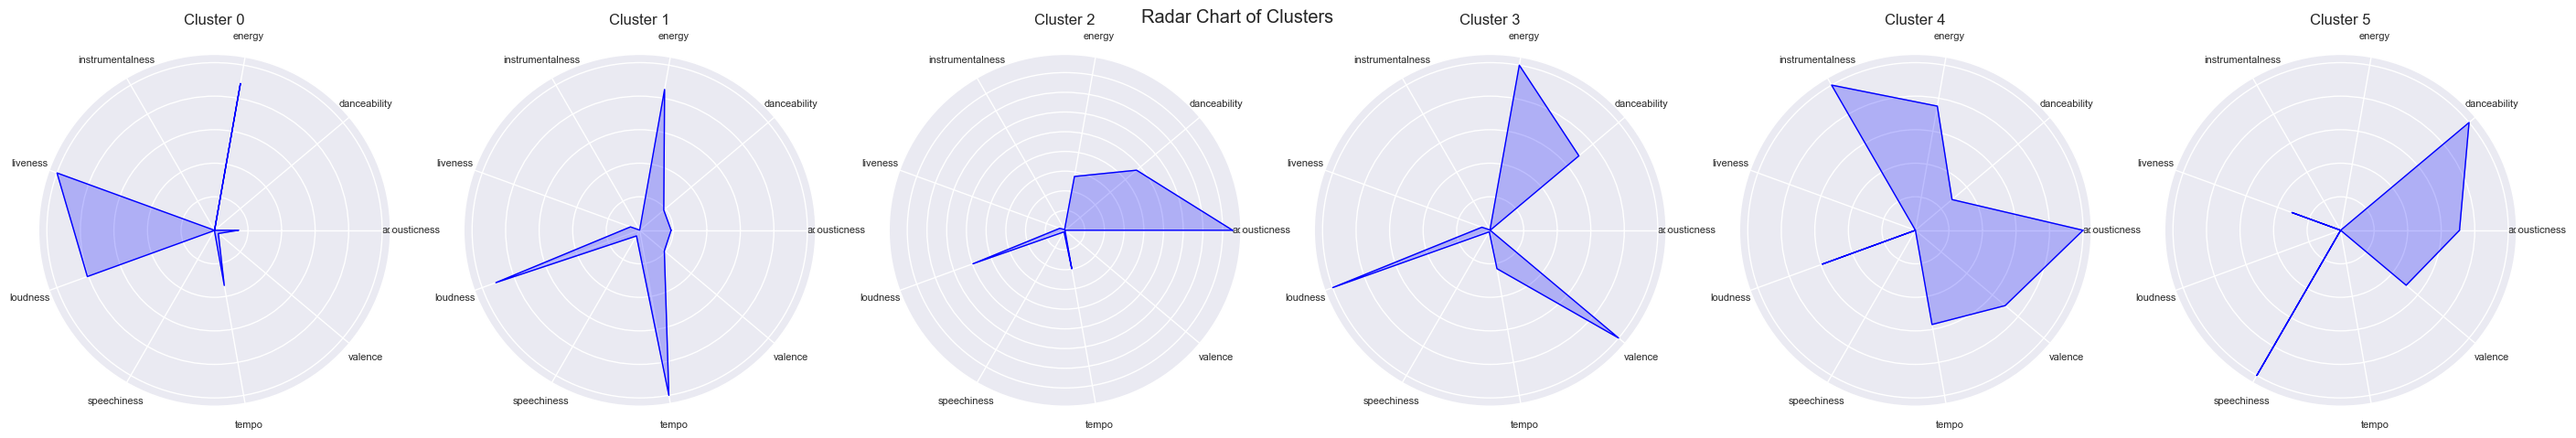

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Filter numeric columns excluding 'key'
numeric_columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                   'liveness',  'loudness', 'speechiness', 
                   'tempo', 'valence']

# Select numeric columns and 'cluster' column
cluster_data = df[['cluster'] + numeric_columns]

# Drop rows with NaN values
cluster_data.dropna(inplace=True)

# Group by 'cluster' and calculate mean values
cluster_means = cluster_data.groupby('cluster').mean()

# Normalize the mean values using Min-Max scaling
scaler = MinMaxScaler()
cluster_means_normalized = scaler.fit_transform(cluster_means)

# Define the features for the radar chart
features = numeric_columns

# Define the number of clusters
num_clusters = len(cluster_means_normalized)

# Create a function to plot radar charts
def plot_radar_chart(ax, values, category_labels, title):
    num_vars = len(values)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))  # Close the loop
    angles += angles[:1]  # Ensure that the plot is closed
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=1, linestyle='solid')
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(category_labels, fontsize=8)
    ax.set_title(title, fontsize=12)

# Create subplots for each cluster
fig, axs = plt.subplots(nrows=1, ncols=num_clusters, subplot_kw=dict(polar=True), figsize=(35, 5))
fig.suptitle('Radar Chart of Clusters')

# Plot radar charts for each cluster
for i, ax in enumerate(axs):
    values = cluster_means_normalized[i]
    plot_radar_chart(ax, values, features, f'Cluster {i}')

plt.show()


In [224]:
# 按照簇进行分组，并打印每个簇的专辑名称
for i in range(num_clusters):
    print(f'Cluster {i+1} 专辑名称:')
    albums_in_cluster = df[df['cluster'] == i]['name'].unique()
    for album_name in albums_in_cluster:
        print(album_name)
    print('\n')


Cluster 1 专辑名称:
Karma
august - the long pond studio sessions
Sparks Fly - Live/2011
Mine - Live/2011
The Story Of Us - Live
Mean - Live/2011
Ours - Live/2011
Back To December/Apologize/You're Not Sorry - Live/2011/Medley
Better Than Revenge - Live/2011
Speak Now - Live/2011
Last Kiss - Live/2011
Drops Of Jupiter - Live/2011
Bette Davis Eyes - Live/2011
Dear John - Live/2011
Enchanted - Live/2011
Haunted - Live/2011
Long Live - Live/2011


Cluster 2 专辑名称:
Fortnight (feat. Post Malone)
So Long, London
Florida!!! (feat. Florence + The Machine)
The Albatross
So High School
The Prophecy
Peter
The Bolter
Bad Blood (feat. Kendrick Lamar) (Taylor's Version)
Electric Touch (feat. Fall Out Boy) (Taylor’s Version) (From The Vault)
Castles Crumbling (feat. Hayley Williams) (Taylor’s Version) (From The Vault)
Bejeweled
High Infidelity
Would've, Could've, Should've
I Bet You Think About Me (feat. Chris Stapleton) (Taylor’s Version) (From The Vault)
mad woman
Cruel Summer
The Archer
...Ready For It?


C:\Users\wuyuh\AppData\Local\Temp\ipykernel_21508\731353484.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


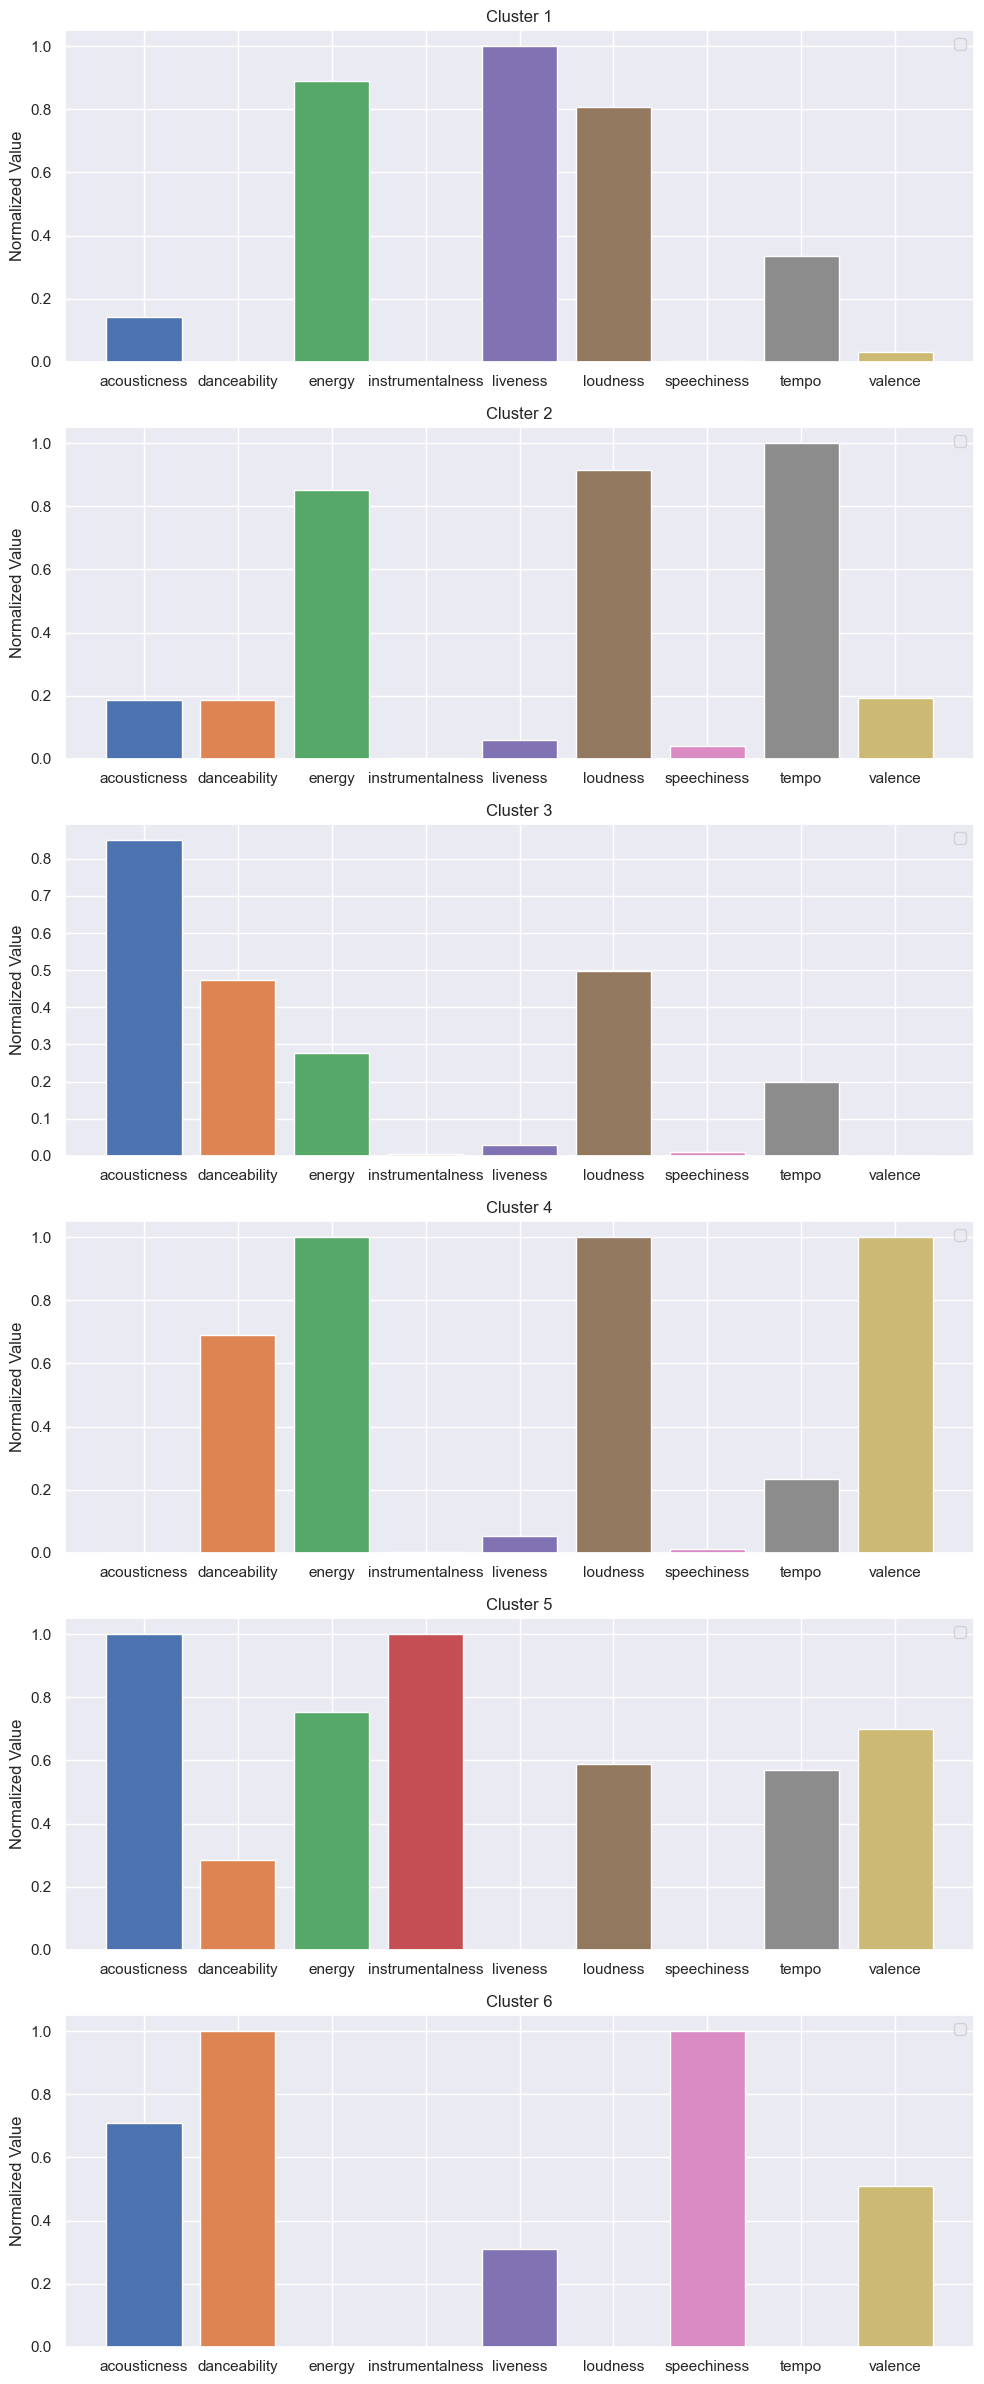

In [225]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Group by 'cluster' and calculate mean values
cluster_means = cluster_data.groupby('cluster').mean()

# Normalize the mean values using Min-Max scaling
scaler = MinMaxScaler()
cluster_means_normalized = scaler.fit_transform(cluster_means)

# Define the number of clusters and features
num_clusters = len(cluster_means_normalized)
num_features = len(numeric_columns)

# Create subplots for each cluster
fig, axs = plt.subplots(num_clusters, 1, figsize=(10, num_clusters*4))

# Plot bar plots for each cluster
for i in range(num_clusters):
    for j, feature in enumerate(numeric_columns):
        axs[i].bar(feature, cluster_means_normalized[i, j], )
    axs[i].set_title(f'Cluster {i+1}')
    axs[i].set_ylabel('Normalized Value')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [226]:
df

,Unnamed: 0,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,...,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,pca_1,pca_2,cluster
0,0,Fortnight (feat. Post Malone),THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,1,6dODwocEuGzHAavXqTbwHv,spotify:track:6dODwocEuGzHAavXqTbwHv,0.50200,0.504,0.386,...,0.0961,-10.976,0.0308,192.004,0.281,89,228965,-1.272378,-1.254763,1
1,1,The Tortured Poets Department,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,2,4PdLaGZubp4lghChqp8erB,spotify:track:4PdLaGZubp4lghChqp8erB,0.04830,0.604,0.428,...,0.1260,-8.441,0.0255,110.259,0.292,87,293048,-0.277340,0.147820,2
2,2,My Boy Only Breaks His Favorite Toys,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,3,7uGYWMwRy24dm7RUDDhUlD,spotify:track:7uGYWMwRy24dm7RUDDhUlD,0.13700,0.596,0.563,...,0.3020,-7.362,0.0269,97.073,0.481,88,203801,0.501912,0.215389,3
3,3,Down Bad,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,4,1kbEbBdEgQdQeLXCJh28pJ,spotify:track:1kbEbBdEgQdQeLXCJh28pJ,0.56000,0.541,0.366,...,0.0946,-10.412,0.0748,159.707,0.168,89,261228,-1.692547,-0.779578,2
4,4,"So Long, London",THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,5,7wAkQFShJ27V8362MqevQr,spotify:track:7wAkQFShJ27V8362MqevQr,0.73000,0.423,0.533,...,0.0816,-11.388,0.3220,160.218,0.248,88,262974,-1.939109,-0.491485,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,561,Our Song,Taylor Swift,2006-10-24,11,1j6gmK6u4WNI33lMZ8dC1s,spotify:track:1j6gmK6u4WNI33lMZ8dC1s,0.11100,0.668,0.672,...,0.3290,-4.931,0.0303,89.011,0.539,65,201106,1.411801,0.718083,3
318,562,I'm Only Me When I'm With You,Taylor Swift,2006-10-24,12,7CzxXgQXurKZCyHz9ufbo1,spotify:track:7CzxXgQXurKZCyHz9ufbo1,0.00452,0.563,0.934,...,0.1030,-3.629,0.0646,143.964,0.518,55,213053,2.588645,-0.100847,3
319,563,Invisible,Taylor Swift,2006-10-24,13,1k3PzDNjg38cWqOvL4M9vq,spotify:track:1k3PzDNjg38cWqOvL4M9vq,0.63700,0.612,0.394,...,0.1470,-5.723,0.0243,96.001,0.233,53,203226,-0.897348,0.039295,2
320,564,A Perfectly Good Heart,Taylor Swift,2006-10-24,14,0YgHuReCSPwTXYny7isLja,spotify:track:0YgHuReCSPwTXYny7isLja,0.00349,0.483,0.751,...,0.1280,-5.726,0.0365,156.092,0.268,52,220146,1.321718,-1.280881,1


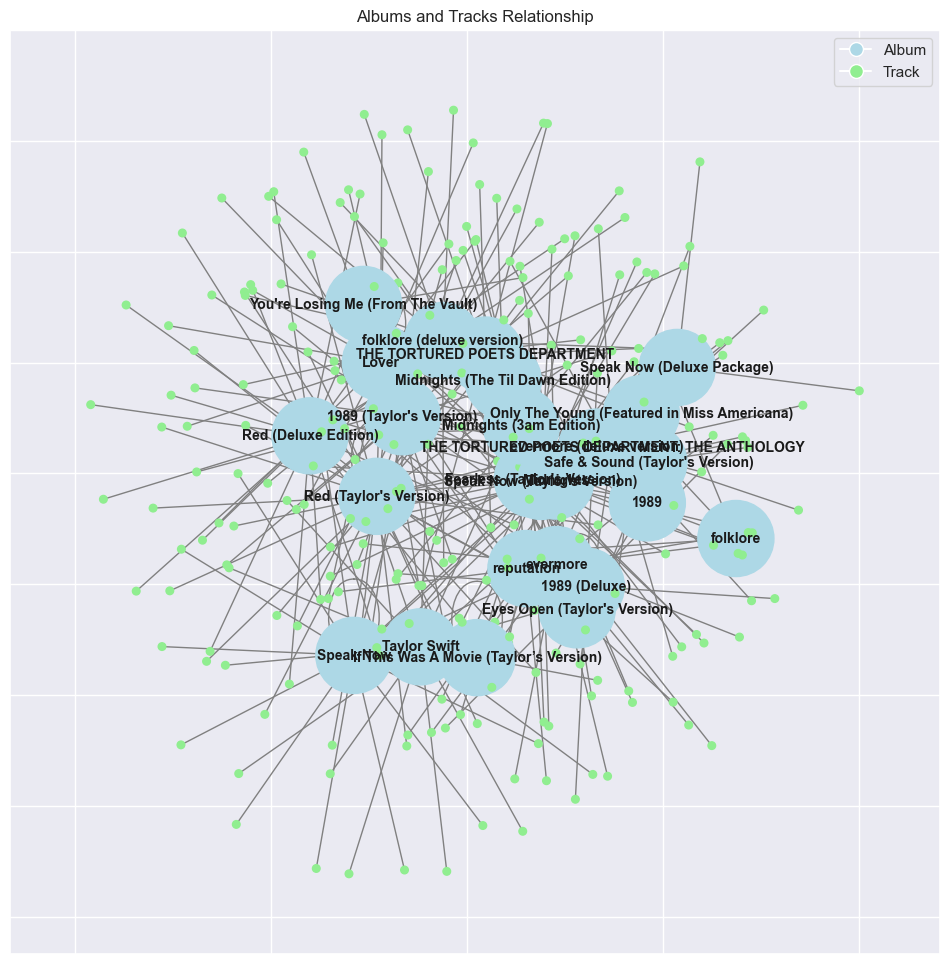

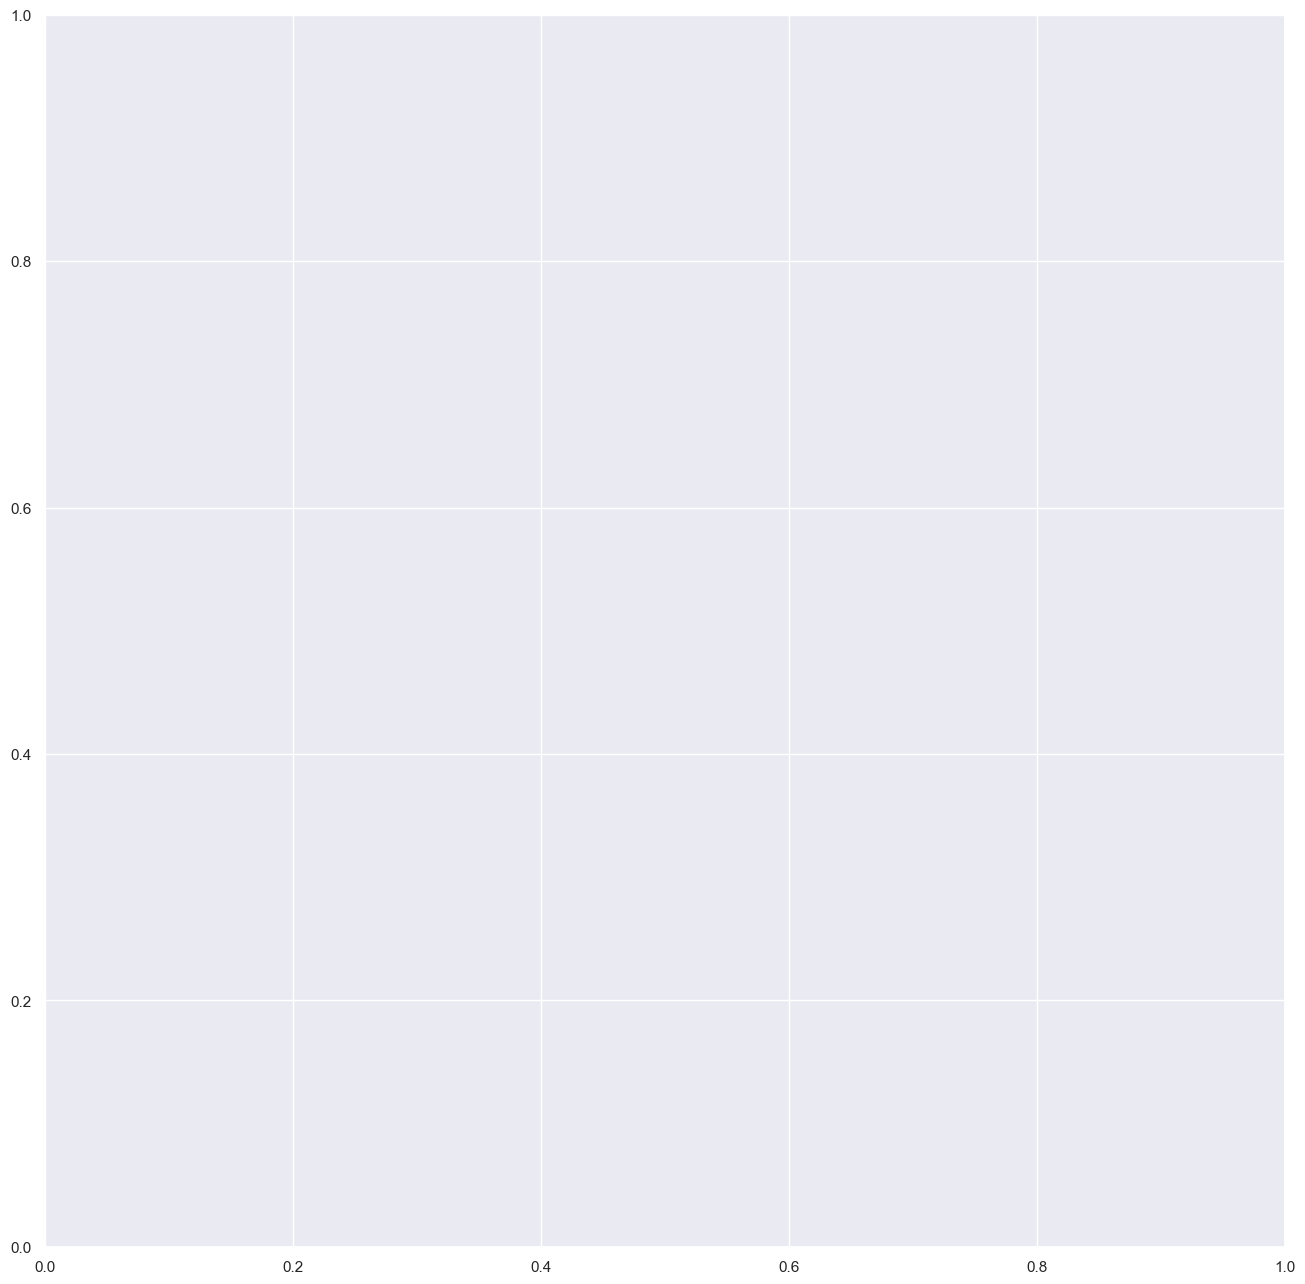

In [79]:
my_songs_df = pd.DataFrame(columns=['track_name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'mode', 'loudness', 'speechiness', 'tempo', 'valence'])

sp = spotipy.Spotify(auth=get_token('user-read-recently-played'))
recent_tracks = [x['track'] for x in sp.current_user_recently_played()['items']]

for track in recent_tracks:
    track_name = track['name']
    artist = track['artists'][0]['name']
    track_uri = track['uri']
    
    # access audio features for given track URI via spotipy
    audio_features = sp.audio_features(track_uri)
    
    # get relevant audio features
    feature_subset = [audio_features[0][col] for col in my_songs_df.columns if col not in ["track_name", "artist", "track_URI"]]

    # compose a row of the dataframe by flattening the list of audio features
    row = [track_name, artist, track_uri, *feature_subset]
    my_songs_df.loc[len(my_songs_df.index)] = row

my_songs_df = treat_nans(my_songs_df)
my_songs_df

,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,♾,Coldplay,spotify:track:2wleRXcIPqltoDPLMH5WDa,0.009410,0.5760,0.8960,0.955000,2,0.1530,1,-8.994,0.0412,135.010,0.4120
1,❤️,Coldplay,spotify:track:3oTYv0yShT4sjuPncoUXfK,0.970000,0.3480,0.0491,0.000186,4,0.0918,1,-15.431,0.0404,136.680,0.2320
2,🌎,Coldplay,spotify:track:0RbekAlUrwR6ZWJdwB3V4y,0.969000,0.1150,0.9070,0.981000,3,0.9800,1,-20.358,0.2230,189.885,0.0185
3,People of The Pride,Coldplay,spotify:track:5ophZLHA9mwSZhQSmboyDN,0.005810,0.4320,0.6130,0.015100,4,0.3120,0,-6.785,0.0349,136.362,0.0911
4,Humankind,Coldplay,spotify:track:23BO6YozrAXUta1buxFZ80,0.000172,0.5750,0.8380,0.000103,2,0.4580,1,-6.498,0.0454,135.006,0.2150
5,Let Somebody Go,Coldplay,spotify:track:4cGqn0E8JCSY9gQllQj4Mf,0.193000,0.5920,0.3420,0.002450,0,0.1100,1,-8.930,0.0339,130.953,0.1550
6,✨,Coldplay,spotify:track:1danObd53GynoY83wRz3Ua,0.805000,0.0859,0.2890,0.990000,5,0.1410,0,-17.240,0.0359,166.784,0.0380
7,Biutyful,Coldplay,spotify:track:2L2mM3rEO3arNIMQnb3dou,0.016800,0.6140,0.6800,0.000560,5,0.1180,0,-7.840,0.0425,153.937,0.3470
8,🪐,Coldplay,spotify:track:1a3G9SNslcKsPAOuIikaxd,0.887000,0.3260,0.3220,0.841000,5,0.1160,1,-20.192,0.0337,89.657,0.0651
9,My Universe,Coldplay,spotify:track:46HNZY1i7O6jwTA7Slo2PI,0.008130,0.5880,0.7010,0.000000,9,0.2000,1,-6.390,0.0402,104.988,0.4430


In [100]:
sp = spotipy.Spotify(auth=get_token('playlist-read-private'))

playlist_df = pd.DataFrame(columns=['track_name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'mode', 'loudness', 'speechiness', 'tempo', 'valence'])

playlist_df = get_features_for_playlist(playlist_df, user_config['username'], 'spotify:playlist:5hvgiq3c8IFnaBgbwDcttd')

playlist_df = treat_nans(playlist_df)
playlist_df


,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,Settle,Two Door Cinema Club,spotify:track:7rOneF5Ox2DarSh4557VXX,0.00647,0.487,0.775,0.061400,0,0.0893,1,-5.877,0.0375,131.862,0.163
1,Punching In A Dream,The Naked And Famous,spotify:track:5PtEpuVX03k9bOUwilL5EO,0.00201,0.473,0.883,0.000967,6,0.1420,1,-3.650,0.0470,115.048,0.164
2,Jubel - Nora En Pure Remix,Klingande,spotify:track:0UmBBoADlU9Vy7irHCKseL,0.00287,0.743,0.766,0.456000,0,0.0917,1,-5.401,0.0326,124.993,0.625
3,higher,pluko,spotify:track:5Rddx0DkGh79Lq0TfZ9GiW,0.03920,0.624,0.568,0.000256,1,0.1290,1,-8.905,0.0591,91.009,0.282
4,Die For It (ft. Nas),Belly,spotify:track:3JvdrCezbM6DQOjNiBiX5q,0.37100,0.689,0.487,0.000000,5,0.4280,0,-9.585,0.0791,97.043,0.215
5,Moonwalk,Rexx Life Raj,spotify:track:0bJQ2EJndGgy6gN63wSHty,0.41100,0.706,0.480,0.000000,0,0.1030,1,-10.421,0.2980,75.050,0.682
6,Your Way,Rexx Life Raj,spotify:track:5sc7JPdQFdWiwyZtl2kjal,0.63000,0.718,0.328,0.000000,3,0.1050,0,-10.958,0.0302,99.966,0.720
7,One Man Can Change The World,Big Sean,spotify:track:731Pa6Gt7GAdADATMSEL0N,0.77700,0.670,0.580,0.000000,8,0.1100,0,-6.586,0.1440,157.997,0.309
8,cbb to b sad,IDER,spotify:track:56b4sQ1Sxi3ox5CoCmcp49,0.30400,0.705,0.765,0.000766,0,0.1380,1,-8.246,0.0772,101.988,0.714
9,Lighter (with Tarrus Riley & Rvssian),Shenseea,spotify:track:1AAkIj1NSdpaoOZYctGnrg,0.16200,0.521,0.682,0.000000,1,0.1000,0,-5.642,0.1400,177.826,0.208


In [113]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def get_recommendations_using_mean(input_songs, discovery_songs, num_recs):
    scaler = StandardScaler().fit(discovery_songs.select_dtypes(np.number))
    scaled_data = scaler.transform(discovery_songs.select_dtypes(np.number))

    song_center = np.mean(input_songs.select_dtypes(np.number).values, axis=0)
    scaled_song_center = scaler.transform(song_center.reshape(1,-1))

    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :num_recs][0])
    rec_songs = discovery_songs.iloc[index]
    rec_songs = rec_songs[~rec_songs['track_name'].isin(input_songs['track_name'])]
    return rec_songs

def get_recommendations_one_to_one(input_songs, discovery_songs):
    scaler = StandardScaler().fit(discovery_songs.select_dtypes(np.number))
    scaled_data = scaler.transform(discovery_songs.select_dtypes(np.number))

    rec_indices = []
    for i, row in enumerate(input_songs.select_dtypes(np.number).values):
        source_song = scaler.transform(row.reshape(1, -1))
        distances = cdist(source_song, scaled_data, 'cosine')
        best_rec_index = np.argmax(distances)
        rec_indices.append(best_rec_index)

    rec_songs = discovery_songs.iloc[rec_indices]
    rec_songs = rec_songs[~rec_songs['track_name'].isin(input_songs['track_name'])]
    return rec_songs



In [114]:
get_recommendations_using_mean(playlist_df, df, 20)[['track_name', 'artist']]

,track_name,artist
1632,Vaselina (feat. euro),Ramengvrl
1649,Buff Baby,tobi lou
743,SIERRA NIGHTS (feat. Ryan Beatty),Kevin Abstract
123,6 months,John K
787,NO HALO,BROCKHAMPTON
1671,Tarian Penghancur Raya,.Feast
1248,Reckless,Arin Ray
1779,HUMBLE.,Kendrick Lamar
1338,Nowhere to Run (feat. Bryson Tiller),Ryan Trey
1430,VILLAIN,K/DA


In [115]:
one_to_one_df = get_recommendations_one_to_one(playlist_df, df)
source_dest_df = pd.concat([playlist_df[['track_name', 'artist']].reset_index(drop=True), one_to_one_df[['track_name', 'artist']].reset_index(drop=True)], axis=1, ignore_index=True)
source_dest_df.columns = ['Source Track', 'Source Artist', 'Recommended Track', 'Recommended Artist']
source_dest_df

,Source Track,Source Artist,Recommended Track,Recommended Artist
0,Settle,Two Door Cinema Club,Ginny,Sylo Nozra
1,Punching In A Dream,The Naked And Famous,Story,ODIE
2,Jubel - Nora En Pure Remix,Klingande,Needs,ELHAE
3,higher,pluko,Losing My Love,Verzache
4,Die For It (ft. Nas),Belly,CONVERSATIONS,Aries
5,Moonwalk,Rexx Life Raj,Pacify Her,Melanie Martinez
6,Your Way,Rexx Life Raj,Beautiful & Brutal,Plested
7,One Man Can Change The World,Big Sean,Waterfalls,Coast Modern
8,cbb to b sad,IDER,Call Me,NAV
9,Lighter (with Tarrus Riley & Rvssian),Shenseea,Selfish,Stephanie Poetri


In [119]:
src_df = playlist_df.copy()
src_df.reset_index(drop=True, inplace=True)
src_df.insert(3, 'label', pd.Series(['source']*len(src_df)))
rec_df = one_to_one_df.copy()
rec_df.reset_index(drop=True, inplace=True)
rec_df.insert(3, 'label', pd.Series(['recommended']*len(rec_df)))
src_rec_df = pd.concat([src_df, rec_df], axis=0).reset_index(drop=True)
src_rec_df

,track_name,artist,track_URI,label,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,Settle,Two Door Cinema Club,spotify:track:7rOneF5Ox2DarSh4557VXX,source,0.00647,0.487,0.775,0.061400,0,0.0893,1,-5.877,0.0375,131.862,0.163
1,Punching In A Dream,The Naked And Famous,spotify:track:5PtEpuVX03k9bOUwilL5EO,source,0.00201,0.473,0.883,0.000967,6,0.1420,1,-3.650,0.0470,115.048,0.164
2,Jubel - Nora En Pure Remix,Klingande,spotify:track:0UmBBoADlU9Vy7irHCKseL,source,0.00287,0.743,0.766,0.456000,0,0.0917,1,-5.401,0.0326,124.993,0.625
3,higher,pluko,spotify:track:5Rddx0DkGh79Lq0TfZ9GiW,source,0.03920,0.624,0.568,0.000256,1,0.1290,1,-8.905,0.0591,91.009,0.282
4,Die For It (ft. Nas),Belly,spotify:track:3JvdrCezbM6DQOjNiBiX5q,source,0.37100,0.689,0.487,0.000000,5,0.4280,0,-9.585,0.0791,97.043,0.215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Hiccup,Verzache,spotify:track:0u256fkohocCZSCJ8J79TX,recommended,0.65400,0.519,0.414,0.001100,4,0.1180,0,-9.059,0.1220,96.789,0.108
92,Moonlight,Jarreau Vandal,spotify:track:4rdQivUpY3faWSm98gMplo,recommended,0.81000,0.710,0.611,0.000148,10,0.1190,0,-6.979,0.2720,85.609,0.202
93,1 hour and 15 minutes,11:11,spotify:track:2zCi2KHsUWTCPQ95AZhGJT,recommended,0.24500,0.591,0.298,0.000000,1,0.1480,1,-12.351,0.2090,135.933,0.738
94,Money,Kyle Dion,spotify:track:35sUj3iM8CmdS8NcfIbFMo,recommended,0.08100,0.684,0.599,0.000000,2,0.2870,1,-5.184,0.0659,70.974,0.466


## Principal Component Analysis (PCA)

In [120]:
non_features = ['track_name', 'artist', 'track_URI', 'label']
track_info = src_rec_df[non_features]
df_X = src_rec_df.select_dtypes(np.number)
df_X.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,0.00647,0.487,0.775,0.061400,0,0.0893,1,-5.877,0.0375,131.862,0.163
1,0.00201,0.473,0.883,0.000967,6,0.1420,1,-3.650,0.0470,115.048,0.164
2,0.00287,0.743,0.766,0.456000,0,0.0917,1,-5.401,0.0326,124.993,0.625
3,0.03920,0.624,0.568,0.000256,1,0.1290,1,-8.905,0.0591,91.009,0.282
4,0.37100,0.689,0.487,0.000000,5,0.4280,0,-9.585,0.0791,97.043,0.215


In [121]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

In [122]:
pca = PCA()
pca.fit(X_std);

In [123]:
# The attribute shows how much variance is explained by each of the nine features
evr = pca.explained_variance_ratio_
evr

array([0.24290099, 0.14227668, 0.12072078, 0.11433023, 0.09624495,
       0.0867553 , 0.07373462, 0.0466425 , 0.03804211, 0.02697767,
       0.01137418])

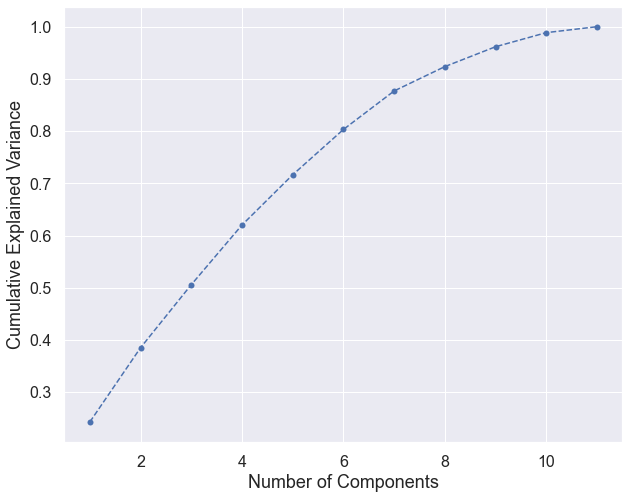

In [124]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [125]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

Number of components: 6


In [132]:
df_seg_pca = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca['label'] = track_info['label']
df_seg_pca.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,label
0,0.00647,0.487,0.775,0.061400,0,0.0893,1,-5.877,0.0375,131.862,0.163,-1.275086,-0.725084,-1.923328,-2.233494,0.439471,0.095880,source
1,0.00201,0.473,0.883,0.000967,6,0.1420,1,-3.650,0.0470,115.048,0.164,-1.757170,0.837882,-1.653249,-2.224321,0.161200,0.060273,source
2,0.00287,0.743,0.766,0.456000,0,0.0917,1,-5.401,0.0326,124.993,0.625,-3.075910,-2.717368,0.629383,-0.580705,2.207282,1.926288,source
3,0.03920,0.624,0.568,0.000256,1,0.1290,1,-8.905,0.0591,91.009,0.282,-0.115540,-1.018286,-1.725853,-0.091017,0.445281,-0.210166,source
4,0.37100,0.689,0.487,0.000000,5,0.4280,0,-9.585,0.0791,97.043,0.215,1.261816,1.414784,-0.644702,0.669354,0.972729,0.544366,source


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



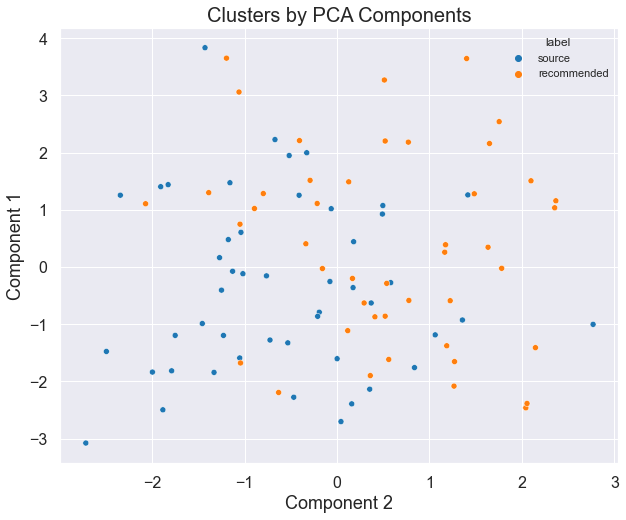

In [137]:
import plotly
x = df_seg_pca['Component 2']
y = df_seg_pca['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca['label'], palette = ['tab:blue', 'tab:orange'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
# fig.savefig("./visualizations/clusters-2d.png")

In [28]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df

,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
0,False Confidence,Noah Kahan,spotify:track:7nDFTHHwfe32a8qdp9XqPy,0.16300,0.414,0.663,0,0.1380,-7.770,0.0456,108.980,0.330,5
1,Someone Like You (feat. Joy Oladokun),Noah Kahan,spotify:track:0hiHNxqKGf3GZgVTIOAiiK,0.46800,0.614,0.526,0,0.0939,-7.492,0.0603,177.913,0.366,5
2,Hurt Somebody,Noah Kahan,spotify:track:2Zg0aB5oVQlbQE1vzQmIIY,0.34400,0.638,0.510,0,0.2120,-6.485,0.3050,114.576,0.448,2
3,Mess,Noah Kahan,spotify:track:1BlQWQgGP84r4GYUVty4Ar,0.17600,0.442,0.826,0,0.0978,-5.320,0.0775,80.848,0.601,5
4,Part of Me,Noah Kahan,spotify:track:1o5WgxPWvoVgo20DQItKOE,0.06770,0.689,0.687,0,0.0805,-7.832,0.0376,109.986,0.248,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,Put Your Hands Up,Forest Blakk,spotify:track:57X2jAov78d6K39SOWJqaJ,0.18400,0.627,0.653,4.29e-05,0.0958,-7.291,0.0476,124.999,0.388,5
2004,If You Love Her - Acoustic,Forest Blakk,spotify:track:615LwsUs7WA2KvSRRmXAUK,0.85200,0.516,0.257,0,0.1100,-11.063,0.0331,153.617,0.444,3
2005,If You Love Her - Mark McCabe Remix,Forest Blakk,spotify:track:2MaGdDg1cbXTywMf93cEZt,0.00179,0.587,0.806,1.56e-06,0.0928,-5.098,0.0344,122.971,0.404,5
2006,I Wish I Knew,Forest Blakk,spotify:track:59fi2USYlHpzOOfjlPenJI,0.64600,0.575,0.566,0,0.2440,-7.417,0.0233,107.033,0.294,3


In [29]:
def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,track_name,artist,track_URI,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,False Confidence,Noah Kahan,spotify:track:7nDFTHHwfe32a8qdp9XqPy,5,0.166493,0.264865,0.659292,0.0,0.117771,0.710385,0.028096,0.372869,0.311724
1,Someone Like You (feat. Joy Oladokun),Noah Kahan,spotify:track:0hiHNxqKGf3GZgVTIOAiiK,5,0.478037,0.535135,0.516983,0.0,0.071399,0.721833,0.046617,0.814858,0.349611
2,Hurt Somebody,Noah Kahan,spotify:track:2Zg0aB5oVQlbQE1vzQmIIY,2,0.351376,0.567568,0.500364,0.0,0.195584,0.763301,0.354920,0.408750,0.435908
3,Mess,Noah Kahan,spotify:track:1BlQWQgGP84r4GYUVty4Ar,5,0.179772,0.302703,0.828607,0.0,0.075499,0.811275,0.068288,0.192490,0.596927
4,Part of Me,Noah Kahan,spotify:track:1o5WgxPWvoVgo20DQItKOE,5,0.069149,0.636486,0.684221,0.0,0.057308,0.707832,0.018017,0.379319,0.225426


In [34]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

In [ ]:
sp = spotipy.Spotify(auth=get_token('user-read-recently-played'))
recent_track_names = [x['track']['name'] for x in sp.current_user_recently_played()['items']]
recent_tracks = [x['track']['uri'] for x in sp.current_user_recently_played()['items']]
recent_track_names